# Testing for E1 - using all spindles, training with all data
fistly define the UUID of the experiment to use

In [47]:
experimentId="526685ff-765e-4c02-b4aa-23958be9563f"

-------------------------------------------------------

In [48]:
#external libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import plotly
import plotly.subplots as sb
import plotly.express as px
import plotly.graph_objects as go
import dotenv
import pandas as pd
import scipy.fft as fft
import scipy.signal as sg
import scipy.io as sio
import pickle as pkl
import xgboost as xgb
import time
import sklearn.metrics as skm

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']
cognipath=datapath+"\\COGNITION"
dreamspath=datapath+"\\DREAMS"
masspath=datapath+"\\MASS"


## Define classical F1 

In [ ]:
def annotationPairToMetrics_oldF1(annotations,detections,thresIoU=0.3):
    #get the coords
    gtCoords=zip(annotations.startInd,annotations.stopInd)
    outCoords=zip(detections.startInd,detections.stopInd)
    #calculate the iou vector
    iouVector=np.array(list(itt.starmap(getIou,itt.product(gtCoords,outCoords))))
    #reshape to a matrix
    iouMatrix=iouVector.reshape(len(annotations),len(detections))
    #binarize
    binarized=iouMatrix>thresIoU
    #calculateF1 the old way
    N=len(annotations)
    M=len(detections)
    TP=np.sum(np.max(binarized,axis=0))
    FN=N-TP
    FP=M-TP

    outF1=(2*TP)/(2*TP+FN+FP)
    recall=TP/N
    precision=TP/M

    #calculateF1*
    """ outF1=(np.sum(np.max(binarized,axis=0))+np.sum(np.max(binarized,axis=1)))/(len(annotations)+len(detections))
    recall=np.sum(np.max(binarized,axis=1))/len(annotations)
    precision=np.sum(np.max(binarized,axis=0))/len(detections) """
    return outF1,recall,precision

## load mass

In [49]:
samplerate=200  #Should rethink this

In [50]:
annotations, signalsMetadata = loadMASSSpindles(masspath,forceSamplerate=samplerate)

In [51]:
#consider to include this in a function
minDuration=0.3
maxDuration=5
annotations=annotations[annotations.type=='spindle']
annotations=annotations[annotations.duration>minDuration]
annotations=annotations[annotations.duration<maxDuration]
annotations=annotations.reset_index(drop=True)

In [52]:
#check with EDA results (not needed)
print(1-len(annotations)/33458)

0.005648873214178951


In [53]:
annotations.head()

,type,expert,subjectId,labelerId,startTime,duration,samplerate,stopTime,startInd,stopInd
0,spindle,E1,0001,0001,888.327805,0.640579,200,888.968384,177666,177794
1,spindle,E1,0001,0001,905.758061,0.578094,200,906.336155,181152,181267
2,spindle,E1,0001,0001,917.731574,0.847603,200,918.579177,183546,183716
3,spindle,E1,0001,0001,922.078189,0.878845,200,922.957034,184416,184591
4,spindle,E1,0001,0001,939.055445,0.757767,200,939.813212,187811,187963


In [54]:
signalsMetadata.head()

,subjectId,file,channel,duration,samplerate,isOriginalSamplerate,database
0,0001,MASS_0001.pkl,C3-CLE,28956.0,200,False,MASS
1,0002,MASS_0002.pkl,C3-CLE,35016.0,200,False,MASS
2,0003,MASS_0003.pkl,C3-CLE,36760.0,200,False,MASS
3,0004,MASS_0004.pkl,C3-CLE,28004.0,200,False,MASS
4,0005,MASS_0005.pkl,C3-CLE,31244.0,200,False,MASS


## Load experiment results

In [55]:
experimentModels, featureSelection = loadExperiment(experimentId,datapath)

In [56]:
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,4ecbf9fd-9ea2-41f6-82ce-b88ac9b32b76,0.018639
1,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,510c627b-7f5d-47cf-806f-77699d7869bf,0.020055
2,0001,E1,[0001],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,81fc4ed7-34db-485d-8b93-027a1d57313e,0.021075
3,0001,E1,[0001],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,edd43941-9867-4361-a47e-36b0c1e13e96,0.018331
4,0001,E1,[0001],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,f76f3dc0-a712-49f3-842b-590c783bc6ca,0.019222
5,0001,E1,[0001],"[0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...","[0005, 0006, 0009]",0007,bedbb2e2-c55d-4931-8937-6ff81b1df99a,0.019625
6,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...","[0002, 0017, 0013]",0009,d795bc85-43d1-4349-bf03-fe100d40daf9,0.017824
7,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...","[0017, 0001, 0011]",0010,02e88dcd-63b9-408e-848d-a849fc2567a1,0.017542
8,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...","[0002, 0018, 0007]",0011,a090862a-9778-4431-9c22-e5d33b1a116c,0.015442
9,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...","[0001, 0007, 0010]",0012,e7e4df1d-6250-40e8-bf6c-79a6ed4dbdab,0.016460


In [57]:
#we show the difference in class inbalance for the annotation criteria considered
experimentModels[['criteriumName','spindleTimeRate']].groupby('criteriumName').describe()

spindleTimeRate                                          \
                        count      mean       std       min       25%   
criteriumName                                                           
E1                       15.0  0.018463  0.001834  0.015442  0.017419   
E2                       15.0  0.058320  0.004520  0.052347  0.054965   
union                    15.0  0.059557  0.004579  0.053738  0.055972   

                                             
                    50%       75%       max  
criteriumName                                
E1             0.018331  0.019424  0.022439  
E2             0.056746  0.061623  0.067005  
union          0.058222  0.062711  0.068526

In [58]:
featureSelection

,window,characteristic,bandName,Times_selected
0,2,sigmaIndex,broadband,1000.0
1,2,hjortActivity,sigma,1000.0
2,1.5,sigmaIndex,broadband,1000.0
3,1,hjortActivity,sigma,1000.0
4,1,sigmaIndex,broadband,1000.0
5,2,hjortActivity,beta1,1000.0
6,2,hjortActivity,beta2,1000.0
7,1.5,hjortActivity,sigma,999.0
8,2,hjortMobility,beta1,994.0
9,2,hjortActivity,delta2,986.0


## Hyperparameter definition
this should come from a previous evaluation notebook

In [59]:
auxThres=pd.DataFrame({
    'hyperThres':[0.1, 0.2,0.3, 0.4, 0.5]
})
auxDepth=pd.DataFrame({
    'hyperDepth':[10,20,30,40, 50, 60]
})
auxMinDuration=pd.DataFrame({
    'hyperMinDuration':[0.3]
})
auxMaxDuration=pd.DataFrame({
    'hyperMaxDuration':[5]
})
auxClose=pd.DataFrame({
    'hyperClose':[0.1]
})


hyperParams=pd.merge(auxThres,auxDepth,how='cross')
hyperParams=pd.merge(hyperParams,auxMinDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxMaxDuration,how='cross')
hyperParams=pd.merge(hyperParams,auxClose,how='cross')

hyperParams

,hyperThres,hyperDepth,hyperMinDuration,hyperMaxDuration,hyperClose
0,0.1,10,0.3,5,0.1
1,0.1,20,0.3,5,0.1
2,0.1,30,0.3,5,0.1
3,0.1,40,0.3,5,0.1
4,0.1,50,0.3,5,0.1
5,0.1,60,0.3,5,0.1
6,0.2,10,0.3,5,0.1
7,0.2,20,0.3,5,0.1
8,0.2,30,0.3,5,0.1
9,0.2,40,0.3,5,0.1


## Testing with E1 criterium
we test the optimal points for the prediction threshold and number of boost iterations in the different validation groups

In [60]:
experimentModels=experimentModels[experimentModels.criteriumName=='E1'].reset_index(drop=True)
experimentModels

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,4ecbf9fd-9ea2-41f6-82ce-b88ac9b32b76,0.018639
1,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,510c627b-7f5d-47cf-806f-77699d7869bf,0.020055
2,0001,E1,[0001],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,81fc4ed7-34db-485d-8b93-027a1d57313e,0.021075
3,0001,E1,[0001],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,edd43941-9867-4361-a47e-36b0c1e13e96,0.018331
4,0001,E1,[0001],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,f76f3dc0-a712-49f3-842b-590c783bc6ca,0.019222
5,0001,E1,[0001],"[0001, 0002, 0003, 0010, 0011, 0012, 0013, 001...","[0005, 0006, 0009]",0007,bedbb2e2-c55d-4931-8937-6ff81b1df99a,0.019625
6,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0007, 0010, 0011, 001...","[0002, 0017, 0013]",0009,d795bc85-43d1-4349-bf03-fe100d40daf9,0.017824
7,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0007, 0009, 0012, 001...","[0017, 0001, 0011]",0010,02e88dcd-63b9-408e-848d-a849fc2567a1,0.017542
8,0001,E1,[0001],"[0001, 0003, 0005, 0006, 0009, 0010, 0012, 001...","[0002, 0018, 0007]",0011,a090862a-9778-4431-9c22-e5d33b1a116c,0.015442
9,0001,E1,[0001],"[0002, 0003, 0005, 0006, 0009, 0011, 0013, 001...","[0001, 0007, 0010]",0012,e7e4df1d-6250-40e8-bf6c-79a6ed4dbdab,0.016460


In [61]:
experimentModels_N2 = experimentModels.copy()
experimentModels_N2.head()

,criteriumId,criteriumName,labelerIdList,train,val,test,modelId,spindleTimeRate
0,0001,E1,[0001],"[0003, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0017, 0002, 0006]",0001,4ecbf9fd-9ea2-41f6-82ce-b88ac9b32b76,0.018639
1,0001,E1,[0001],"[0001, 0003, 0005, 0007, 0009, 0010, 0011, 001...","[0006, 0013, 0019]",0002,510c627b-7f5d-47cf-806f-77699d7869bf,0.020055
2,0001,E1,[0001],"[0002, 0005, 0007, 0009, 0010, 0011, 0012, 001...","[0013, 0006, 0001]",0003,81fc4ed7-34db-485d-8b93-027a1d57313e,0.021075
3,0001,E1,[0001],"[0001, 0002, 0003, 0006, 0007, 0009, 0010, 001...","[0018, 0014, 0012]",0005,edd43941-9867-4361-a47e-36b0c1e13e96,0.018331
4,0001,E1,[0001],"[0003, 0007, 0009, 0010, 0011, 0012, 0013, 001...","[0005, 0001, 0002]",0006,f76f3dc0-a712-49f3-842b-590c783bc6ca,0.019222


In [62]:
annotationsN2=pd.read_csv(datapath+'/MASS/annotations/spindlesFilteredN2.csv')
annotationsN2['samplerate']=samplerate
annotationsN2['subjectId']=annotationsN2.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
annotationsN2['labelerId']=annotationsN2.apply(
    lambda row: str(row.labelerId).zfill(4),axis=1)
annotationsN2['stopTime']=annotationsN2.apply(
    lambda row: row.startTime+row.duration , axis=1)
annotationsN2['startInd']=annotationsN2.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
annotationsN2['stopInd']=annotationsN2.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)

In [63]:
## load hypnograms
stagesAnnotations=pd.read_csv(datapath+"\MASS\stages\stages.csv")
stagesAnnotations['samplerate']=samplerate
stagesAnnotations['subjectId']=stagesAnnotations.apply(
    lambda row: str(row.subjectId).zfill(4),axis=1)
stagesAnnotations['stopTime']=stagesAnnotations.apply(
    lambda row: row.startTime+row.duration , axis=1)
stagesAnnotations['startInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.startTime,row.samplerate) , axis=1)
stagesAnnotations['stopInd']=stagesAnnotations.apply(
    lambda row: seconds2index(row.stopTime,row.samplerate) , axis=1)
stagesAnnotations.head(5)

hypnograms={}
for ind, row in signalsMetadata.iterrows():
    subjectId=row.subjectId
    thisStages=stagesAnnotations[stagesAnnotations.subjectId==subjectId]
    excerptDimension=int(row.duration*row.samplerate)
    thisHypnogram=np.ones((excerptDimension,))*np.nan
    for ind_stg, row_stg in thisStages.iterrows():
        thisHypnogram[row_stg.startInd:row_stg.stopInd]=row_stg.value
    hypnograms[subjectId]=thisHypnogram  

In [64]:
rawF1s = []
rawPrecisions = []
rawRecalls = []

rawThres = []
rawDepth = []

f1s = []
precisions = []
recalls = []

eventF1s = []
eventPrecisions = []
eventRecalls = []

checks = []

rawF1s_N2 = []
rawPrecisions_N2 = []
rawRecalls_N2 = []

f1s_N2 = []
precisions_N2 = []
recalls_N2 = []

eventF1s_N2 = []
eventPrecisions_N2 = []
eventRecalls_N2 = []

checks_N2 = []

thisExperimentModels = experimentModels.copy()
for ind, row in thisExperimentModels.iterrows():
    #load model
    print(ind)
    model = loadBooster(row.modelId, experimentId, datapath)
    #initialise lists
    rawF1xs=[]

    

    #iterate validation subjects
    for valSubjectId in row.val:
        print(valSubjectId)
        #Define annotations criterium
        usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
        #Load features and labels
        valFeatures=loadFeatureMatrix([valSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
        valLabels=loadLabelsVector([valSubjectId],usedAnnotations,signalsMetadata,samplerate)
        #Predict
        valDMatrix=xgb.DMatrix(data=valFeatures)
        probabilities=[]
        for i_depth, j_depth in auxDepth.iterrows():
            pred=model.predict(valDMatrix,iteration_range=(0,int(j_depth['hyperDepth'])))
            probabilities.append(pred)
        probabilities=np.array(probabilities)
        f1xs=[]

        
        for ind_hyper,row_hyper in hyperParams.iterrows():
            thisExperimentModels=experimentModels.copy()
            hyperThres=row_hyper.hyperThres
            hyperDepth=int(row_hyper.hyperDepth)
            hyperMinDuration=row_hyper.hyperMinDuration
            hyperMaxDuration=row_hyper.hyperMaxDuration
            hyperClose=row_hyper.hyperClose
            probs=probabilities[auxDepth['hyperDepth']==hyperDepth][0]
            raw=probs>=hyperThres
            #Processed labels
            processed=labelingProcess(raw,hyperClose,hyperMinDuration,samplerate)
            gtAnnotations=labelVectorToAnnotations(valLabels,samplerate)
            detections=labelVectorToAnnotations(processed,samplerate)
            detections=detections[detections.duration<hyperMaxDuration]
            #Metrics
            f,r,p=annotationPairToMetrics(gtAnnotations,detections, thresIoU=0.2)
        
            #Metric appends
            f1xs.append(f)

        rawF1xs.append(np.array(f1xs))

    #statistics of the metrics over the subjects of the validation set
    meanF1s=np.mean(np.array(rawF1xs), axis=0)
    
    optimalInd=hyperParams[meanF1s==np.max(meanF1s)].iloc[0]
    hyperParams_opt=optimalInd
    print(hyperParams_opt)
    hyperThres=hyperParams_opt['hyperThres']
    hyperDepth=int(hyperParams_opt['hyperDepth'])
    hyperMinDuration=hyperParams_opt['hyperMinDuration']
    hyperMaxDuration=hyperParams_opt['hyperMaxDuration']
    hyperClose=hyperParams_opt['hyperClose']
    
    ##
    rawThres.append(hyperThres)
    rawDepth.append(hyperDepth)


    testSubjectId=row.test
    #Define annotations criterium
    usedAnnotations=annotations[annotations.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load features and labels
    testFeatures=loadFeatureMatrix([testSubjectId],featureSelection,signalsMetadata,samplerate,datapath)
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Predict
    testDMatrix=xgb.DMatrix(data=testFeatures)
    probabilities=model.predict(testDMatrix,iteration_range=(0,hyperDepth))
    rawLabels=probabilities>=hyperThres
    #Raw Metrics
    rawTp=np.sum(rawLabels*testLabels)
    rawFp=np.sum(rawLabels*(1-testLabels))
    rawTn=np.sum((1-rawLabels)*(1-testLabels))
    rawFn=np.sum((1-rawLabels)*testLabels)
    #Raw appends
    rawF1s.append(2*rawTp/(2*rawTp+rawFp+rawFn))
    rawPrecisions.append(rawTp/(rawTp+rawFp) )
    rawRecalls.append(rawTp/(rawTp+rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp=np.sum(processedLabels*testLabels)
    fp=np.sum(processedLabels*(1-testLabels))
    tn=np.sum((1-processedLabels)*(1-testLabels))
    fn=np.sum((1-processedLabels)*testLabels)
    #Processed appends
    f1s.append(2*tp/(2*tp+fp+fn))
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

    #By-event metrics
    processedAnnotations=labelVectorToAnnotations(processedLabels,samplerate)
    processedAnnotations=processedAnnotations[processedAnnotations.duration<maxDuration]
    gtAnnotations=labelVectorToAnnotations(testLabels,samplerate)   #<- or just filter the annotations
    f,r,p=annotationPairToMetrics(gtAnnotations,processedAnnotations, thresIoU=0.2)
    print('F1-score')
    print(f)
    #calculate metrics
    eventF1s.append(f)
    eventPrecisions.append(p)
    eventRecalls.append(r)
    
    #N2
    testHypnogram=hypnograms[testSubjectId]
    testN2Mask=testHypnogram==2
    #Define annotations criterium
    usedAnnotations=annotationsN2[annotationsN2.labelerId.isin(row.labelerIdList)].reset_index(drop=True)
    #Load labels
    testLabels=loadLabelsVector([testSubjectId],usedAnnotations,signalsMetadata,samplerate)

    #Apply mask to predictions---------------------------------->
    rawLabels=rawLabels*testN2Mask

    
    #Raw Metrics
    rawTp = np.sum(rawLabels * testLabels)
    rawFp = np.sum(rawLabels * (1 - testLabels))
    rawTn = np.sum((1 - rawLabels) * (1 - testLabels))
    rawFn = np.sum((1 - rawLabels) * testLabels)
    #Raw appends
    rawF1s_N2.append(2 * rawTp / (2 * rawTp + rawFp + rawFn))
    rawPrecisions_N2.append(rawTp / (rawTp + rawFp))
    rawRecalls_N2.append(rawTp / (rawTp + rawFn))
    #Process
    processedLabels=labelingProcess(rawLabels,hyperClose,hyperMinDuration,samplerate)
    #Processed metrics
    tp = np.sum(processedLabels * testLabels)
    fp = np.sum(processedLabels * (1 - testLabels))
    tn = np.sum((1 - processedLabels) * (1 - testLabels))
    fn = np.sum((1 - processedLabels) * testLabels)
    #Processed appends
    f1s_N2.append(2 * tp / (2 * tp + fp + fn))
    precisions_N2.append(tp / (tp + fp))
    recalls_N2.append(tp / (tp + fn))

    #By-event metrics
    processedAnnotations = labelVectorToAnnotations(processedLabels, samplerate)
    gtAnnotations = labelVectorToAnnotations(testLabels, samplerate)  #<- or just filter the annotations
    f, r, p = annotationPairToMetrics(gtAnnotations, processedAnnotations, thresIoU=0.2)
    print('N2 F1-score')
    print(f)
    #calculate metrics
    eventF1s_N2.append(f)
    eventPrecisions_N2.append(p)
    eventRecalls_N2.append(r)

#include metrics in the dataframe
experimentModels['rawF1'] = rawF1s
experimentModels['rawPrecision'] = rawPrecisions
experimentModels['rawRecall'] = rawRecalls

experimentModels['f1'] = f1s
experimentModels['precision'] = precisions
experimentModels['recall'] = recalls

experimentModels['eventF1'] = eventF1s
experimentModels['eventPrecision'] = eventPrecisions
experimentModels['eventRecall'] = eventRecalls

experimentModels['Binarization_Threshold'] = rawF1s
experimentModels['Boosting_Iterations'] = rawPrecisions
#include metrics in the N2 dataframe
experimentModels_N2['rawF1'] = rawF1s_N2
experimentModels_N2['rawPrecision'] = rawPrecisions_N2
experimentModels_N2['rawRecall'] = rawRecalls_N2

experimentModels_N2['f1'] = f1s_N2
experimentModels_N2['precision'] = precisions_N2
experimentModels_N2['recall'] = recalls_N2

experimentModels_N2['eventF1'] = eventF1s_N2
experimentModels_N2['eventPrecision'] = eventPrecisions_N2
experimentModels_N2['eventRecall'] = eventRecalls_N2

experimentModels_N2['Binarization_Threshold'] = rawF1s
experimentModels_N2['Boosting_Iterations'] = rawPrecisions


0
0017
0002
0006
hyperThres           0.2
hyperDepth          40.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 9, dtype: float64
F1-score
0.8137865007180469
N2 F1-score
0.845771144278607
1
0006
0013
0019
hyperThres           0.4
hyperDepth          40.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 21, dtype: float64
F1-score
0.7973605789697744
N2 F1-score
0.8011463844797179
2
0013
0006
0001
hyperThres           0.3
hyperDepth          10.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 12, dtype: float64
F1-score
0.5757575757575758
N2 F1-score
0.6318289786223278
3
0018
0014
0012
hyperThres           0.4
hyperDepth          30.0
hyperMinDuration     0.3
hyperMaxDuration     5.0
hyperClose           0.1
Name: 20, dtype: float64
F1-score
0.7317073170731707
N2 F1-score
0.7489597780859917
4
0005
0001
0002
hyperThres           0.3
hyperDepth          30.0
hyperMinDuration     0.3
hyperM

In [65]:
dumpPickle('experimentModels_ValidationperModel_Testing_E1_IoU-0.2_temp_oldF1.pkl',experimentModels)

In [66]:
experimentModels.columns

Index(['criteriumId', 'criteriumName', 'labelerIdList', 'train', 'val', 'test',
       'modelId', 'spindleTimeRate', 'rawF1', 'rawPrecision', 'rawRecall',
       'f1', 'precision', 'recall', 'eventF1', 'eventPrecision', 'eventRecall',
       'Binarization_Threshold', 'Boosting_Iterations'],
      dtype='object')

In [67]:
fig=px.scatter(experimentModels,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

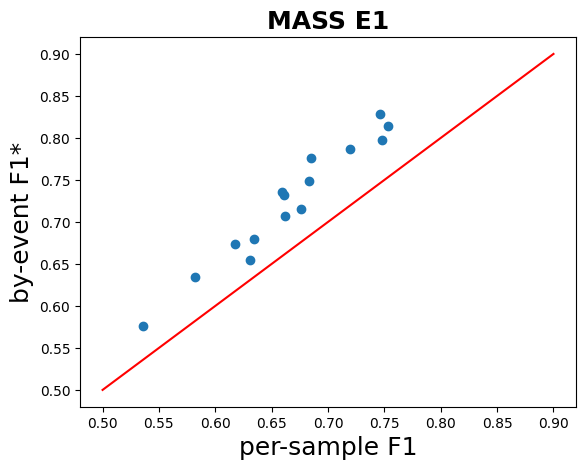

<Figure size 640x480 with 0 Axes>

In [68]:
fig=px.scatter(experimentModels,x='rawF1',y='eventF1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['rawF1'], y=experimentModels['rawF1'], name="identity", mode='lines',fill="toself")
)
ax=plt.subplot()

ax.scatter(experimentModels['rawF1'].to_numpy(), experimentModels['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E1", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#plt.savefig('per-sample_vs_by-event_MASSE1_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

In [69]:
fig=px.scatter(experimentModels,x='eventF1',y='eventPrecision',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [70]:
fig=px.scatter(experimentModels,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [71]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0001     1.0  0.813787 NaN  0.813787  0.813787  0.813787            1.0   
0002     1.0  0.797361 NaN  0.797361  0.797361  0.797361            1.0   
0003     1.0  0.575758 NaN  0.575758  0.575758  0.575758            1.0   
0005     1.0  0.731707 NaN  0.731707  0.731707  0.731707            1.0   
0006     1.0  0.634538 NaN  0.634538  0.634538  0.634538            1.0   
0007     1.0  0.674206 NaN  0.674206  0.674206  0.674206            1.0   
0009     1.0  0.828106 NaN  0.828106  0.828106  0.828106            1.0   
0010     1.0  0.787246 NaN  0.787246  0.787246  0.787246            1.0   
0011     1.0  0.715422 NaN  0.715422  0.715422  0.715422            1.0   
0012     1.0  0.735380 NaN  0.735380  0.735380  0.735380            1.0   
0013     1.0  0.706924 NaN  0.706924  0.706924  0.706924            1.0   
0014     1.0  0.679899 NaN  0.679899  0.679899  0.679899            1.0   
0017     1.0  0.748315 NaN  0.748315  0.748315  0.748315            1.0   
0018     1.0  0.775705 NaN  0.775705  0.775705  0.775705            1.0   
0019     1.0  0.655060 NaN  0.655060  0.655060  0.655060            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0001  0.813397 NaN  0.813397  0.813397  0.813397         1.0  0.814176 NaN   
0002  0.776949 NaN  0.776949  0.776949  0.776949         1.0  0.818898 NaN   
0003  0.416928 NaN  0.416928  0.416928  0.416928         1.0  0.930070 NaN   
0005  0.680101 NaN  0.680101  0.680101  0.680101         1.0  0.791789 NaN   
0006  0.797980 NaN  0.797980  0.797980  0.797980         1.0  0.526667 NaN   
0007  0.559481 NaN  0.559481  0.559481  0.559481         1.0  0.848684 NaN   
0009  0.813981 NaN  0.813981  0.813981  0.813981         1.0  0.842752 NaN   
0010  0.730108 NaN  0.730108  0.730108  0.730108         1.0  0.854088 NaN   
0011  0.571012 NaN  0.571012  0.571012  0.571012         1.0  0.960396 NaN   
0012  0.763278 NaN  0.763278  0.763278  0.763278         1.0  0.709450 NaN   
0013  0.564807 NaN  0.564807  0.564807  0.564807         1.0  0.944126 NaN   
0014  0.528169 NaN  0.528169  0.528169  0.528169         1.0  0.952247 NaN   
0017  0.790476 NaN  0.790476  0.790476  0.790476         1.0  0.710638 NaN   
0018  0.873786 NaN  0.873786  0.873786  0.873786         1.0  0.697595 NaN   
0019  0.498344 NaN  0.498344  0.498344  0.498344         1.0  0.955556 NaN   

                                    
           min       50%       max  
test                                
0001  0.814176  0.814176  0.814176  
0002  0.818898  0.818898  0.818898  
0003  0.930070  0.930070  0.930070  
0005  0.791789  0.791789  0.791789  
0006  0.526667  0.526667  0.526667  
0007  0.848684  0.848684  0.848684  
0009  0.842752  0.842752  0.842752  
0010  0.854088  0.854088  0.854088  
0011  0.960396  0.960396  0.960396  
0012  0.709450  0.709450  0.709450  
0013  0.944126  0.944126  0.944126  
0014  0.952247  0.952247  0.952247  
0017  0.710638  0.710638  0.710638  
0018  0.697595  0.697595  0.697595  
0019  0.955556  0.955556  0.955556

In [72]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0001,0.813787,0.813397,0.814176
1,0002,0.797361,0.776949,0.818898
2,0003,0.575758,0.416928,0.930070
3,0005,0.731707,0.680101,0.791789
4,0006,0.634538,0.797980,0.526667
5,0007,0.674206,0.559481,0.848684
6,0009,0.828106,0.813981,0.842752
7,0010,0.787246,0.730108,0.854088
8,0011,0.715422,0.571012,0.960396
9,0012,0.735380,0.763278,0.709450


In [73]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              6.668000e+54
eventF1           7.239610e-01
eventPrecision    6.785864e-01
eventRecall       8.238087e-01
dtype: float64

In [74]:
experimentModels[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_39996\2599554826.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.071343
eventPrecision    0.142219
eventRecall       0.122889
dtype: float64

In [75]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels.eventPrecision,
    'event F1':experimentModels.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels.eventRecall,
    'event F1':experimentModels.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [76]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels['eventF1'], y=experimentModels['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

## Restrict to only N2 stage

In [77]:
dumpPickle('experimentModelsTest_ValidationperModel_Testing_N2_E1_IoU-0.2_temp.pkl',experimentModels_N2)

In [78]:
fig=px.scatter(experimentModels_N2,x='rawF1',y='f1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['rawF1'], y=experimentModels_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [79]:
fig=px.scatter(experimentModels_N2,x='rawF1',y='eventF1',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['rawF1'], y=experimentModels_N2['rawF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

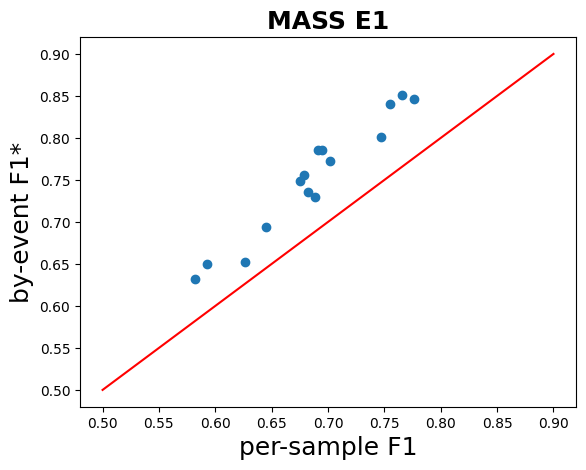

<Figure size 640x480 with 0 Axes>

In [80]:
ax=plt.subplot()

ax.scatter(experimentModels_N2['rawF1'].to_numpy(), experimentModels_N2['eventF1'].to_numpy())
ax.plot([0.5,0.9],[0.5,0.9], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E1", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
#plt.savefig('per-sample_vs_by-event_MASSE1_N2_IoU0-2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

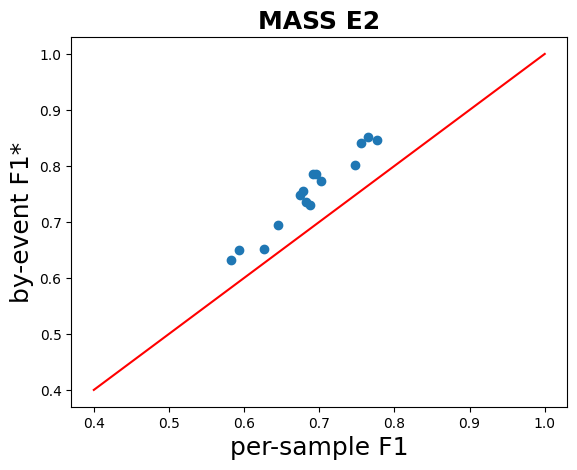

<Figure size 640x480 with 0 Axes>

In [81]:
ax=plt.subplot()

ax.scatter(experimentModels_N2['rawF1'].to_numpy(), experimentModels_N2['eventF1'].to_numpy())
ax.plot([0.4,1],[0.4,1], 'r')
ax.set_ylabel('by-event F1*', fontsize = 18)#, fontweight= 'bold'
ax.set_xlabel('per-sample F1', fontsize = 18)

ax.set_title("MASS E2", fontdict = {'fontsize' : 18, 'fontweight':'bold'})
plt.show()

plt.tight_layout()
plt.savefig('per-sample_vs_by-event_MASSE2_IoU-0.2.png',bbox_inches='tight', dpi=300, format="png") # , pil_kwargs={"compression": "tiff_lzw"}

In [82]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventPrecision',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [83]:
fig=px.scatter(experimentModels_N2,x='eventF1',y='eventRecall',color='test',hover_name='modelId', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

In [84]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test').describe(percentiles=[0.5])

eventF1                                             eventPrecision  \
       count      mean std       min       50%       max          count   
test                                                                      
0001     1.0  0.845771 NaN  0.845771  0.845771  0.845771            1.0   
0002     1.0  0.801146 NaN  0.801146  0.801146  0.801146            1.0   
0003     1.0  0.631829 NaN  0.631829  0.631829  0.631829            1.0   
0005     1.0  0.748960 NaN  0.748960  0.748960  0.748960            1.0   
0006     1.0  0.650206 NaN  0.650206  0.650206  0.650206            1.0   
0007     1.0  0.755361 NaN  0.755361  0.755361  0.755361            1.0   
0009     1.0  0.840269 NaN  0.840269  0.840269  0.840269            1.0   
0010     1.0  0.850877 NaN  0.850877  0.850877  0.850877            1.0   
0011     1.0  0.730057 NaN  0.730057  0.730057  0.730057            1.0   
0012     1.0  0.785603 NaN  0.785603  0.785603  0.785603            1.0   
0013     1.0  0.735343 NaN  0.735343  0.735343  0.735343            1.0   
0014     1.0  0.693846 NaN  0.693846  0.693846  0.693846            1.0   
0017     1.0  0.772622 NaN  0.772622  0.772622  0.772622            1.0   
0018     1.0  0.785092 NaN  0.785092  0.785092  0.785092            1.0   
0019     1.0  0.651885 NaN  0.651885  0.651885  0.651885            1.0   

                                                 eventRecall                \
          mean std       min       50%       max       count      mean std   
test                                                                         
0001  0.879917 NaN  0.879917  0.879917  0.879917         1.0  0.814176 NaN   
0002  0.785653 NaN  0.785653  0.785653  0.785653         1.0  0.817282 NaN   
0003  0.478417 NaN  0.478417  0.478417  0.478417         1.0  0.930070 NaN   
0005  0.710526 NaN  0.710526  0.710526  0.710526         1.0  0.791789 NaN   
0006  0.849462 NaN  0.849462  0.849462  0.849462         1.0  0.526667 NaN   
0007  0.680702 NaN  0.680702  0.680702  0.680702         1.0  0.848684 NaN   
0009  0.837805 NaN  0.837805  0.837805  0.837805         1.0  0.842752 NaN   
0010  0.847690 NaN  0.847690  0.847690  0.847690         1.0  0.854088 NaN   
0011  0.589928 NaN  0.589928  0.589928  0.589928         1.0  0.959596 NaN   
0012  0.879159 NaN  0.879159  0.879159  0.879159         1.0  0.710042 NaN   
0013  0.602013 NaN  0.602013  0.602013  0.602013         1.0  0.944126 NaN   
0014  0.545234 NaN  0.545234  0.545234  0.545234         1.0  0.952247 NaN   
0017  0.846939 NaN  0.846939  0.846939  0.846939         1.0  0.710638 NaN   
0018  0.898004 NaN  0.898004  0.898004  0.898004         1.0  0.697595 NaN   
0019  0.494949 NaN  0.494949  0.494949  0.494949         1.0  0.954545 NaN   

                                    
           min       50%       max  
test                                
0001  0.814176  0.814176  0.814176  
0002  0.817282  0.817282  0.817282  
0003  0.930070  0.930070  0.930070  
0005  0.791789  0.791789  0.791789  
0006  0.526667  0.526667  0.526667  
0007  0.848684  0.848684  0.848684  
0009  0.842752  0.842752  0.842752  
0010  0.854088  0.854088  0.854088  
0011  0.959596  0.959596  0.959596  
0012  0.710042  0.710042  0.710042  
0013  0.944126  0.944126  0.944126  
0014  0.952247  0.952247  0.952247  
0017  0.710638  0.710638  0.710638  
0018  0.697595  0.697595  0.697595  
0019  0.954545  0.954545  0.954545

In [85]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean()

,test,eventF1,eventPrecision,eventRecall
0,0001,0.845771,0.879917,0.814176
1,0002,0.801146,0.785653,0.817282
2,0003,0.631829,0.478417,0.930070
3,0005,0.748960,0.710526,0.791789
4,0006,0.650206,0.849462,0.526667
5,0007,0.755361,0.680702,0.848684
6,0009,0.840269,0.837805,0.842752
7,0010,0.850877,0.847690,0.854088
8,0011,0.730057,0.589928,0.959596
9,0012,0.785603,0.879159,0.710042


In [86]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              6.668000e+54
eventF1           7.519245e-01
eventPrecision    7.284267e-01
eventRecall       8.236198e-01
dtype: float64

In [87]:
experimentModels_N2[['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().std()

C:\Users\GIB\AppData\Local\Temp\ipykernel_39996\292585311.py:1: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



eventF1           0.070919
eventPrecision    0.151403
eventRecall       0.122714
dtype: float64

In [88]:
auxPrecision=pd.DataFrame({
    'metric':'event precision',
    'value':experimentModels_N2.eventPrecision,
    'event F1':experimentModels_N2.eventF1
})

auxRecall=pd.DataFrame({
    'metric':'event recall',
    'value':experimentModels_N2.eventRecall,
    'event F1':experimentModels_N2.eventF1
})
visualTradeoff=pd.concat((auxPrecision,auxRecall))

In [89]:
fig=px.scatter(visualTradeoff,x='event F1',y='value',color='metric', marginal_y="histogram")
fig.add_trace(
    go.Scatter(x=experimentModels_N2['eventF1'], y=experimentModels_N2['eventF1'], name="identity", mode='lines',fill="toself")
)
fig.show()

### remove outliers

In [90]:
np.setdiff1d(experimentModels_N2.test,['0006'])

array(['0001', '0002', '0003', '0005', '0007', '0009', '0010', '0011',
       '0012', '0013', '0014', '0017', '0018', '0019'], dtype=object)

In [91]:
experimentModels_N2[experimentModels_N2.test.isin(np.setdiff1d(experimentModels_N2.test,['0001','0014','0019']))][['test','eventF1','eventPrecision','eventRecall']].groupby('test',as_index=False).mean().mean()

test              1.666917e+43
eventF1           7.572804e-01
eventPrecision    7.505249e-01
eventRecall       8.027774e-01
dtype: float64

In [92]:
annotationPairToGraph(gtAnnotations,processedAnnotations)